In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("_toy_retis.nc", mode="r")

In [2]:
%%time
storage.samples.cache_all()
storage.pathmovechanges.cache_all()

CPU times: user 22.3 s, sys: 4.83 s, total: 27.1 s
Wall time: 30.6 s


In [3]:
print len(storage.steps)

25000


In [4]:
retis = storage.transitions.load(0)
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [5]:
%%time
retis.move_summary(storage)

pathreversal ran 24.82% of the cycles with acceptance 5107/6205 (0.823045930701) 
shooting ran 48.644% of the cycles with acceptance 8930/12161 (0.734314612285) 
minus ran 1.672% of the cycles with acceptance 418/418 (1.0) 
repex ran 24.864% of the cycles with acceptance 2039/6216 (0.328024453024) 
CPU times: user 2min 17s, sys: 10.6 s, total: 2min 28s
Wall time: 2min 28s


In [6]:
retis.move_summary(storage, 'shooting')

OneWayShootingMover I'face 2 ran 7.948% of the cycles with acceptance 1469/1987 (0.739305485657) 
OneWayShootingMover I'face 5 ran 8.184% of the cycles with acceptance 1305/2046 (0.637829912023) 
OneWayShootingMover I'face 3 ran 8.112% of the cycles with acceptance 1442/2028 (0.711045364892) 
OneWayShootingMover I'face 0 ran 8.16% of the cycles with acceptance 1709/2040 (0.837745098039) 
OneWayShootingMover I'face 4 ran 8.22% of the cycles with acceptance 1371/2055 (0.667153284672) 
OneWayShootingMover I'face 1 ran 8.02% of the cycles with acceptance 1634/2005 (0.814962593516) 


In [7]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [8]:
first40 = first_n(storage, 40, trajid=4)

In [9]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 1.96 s, sys: 325 ms, total: 2.28 s
Wall time: 2.33 s


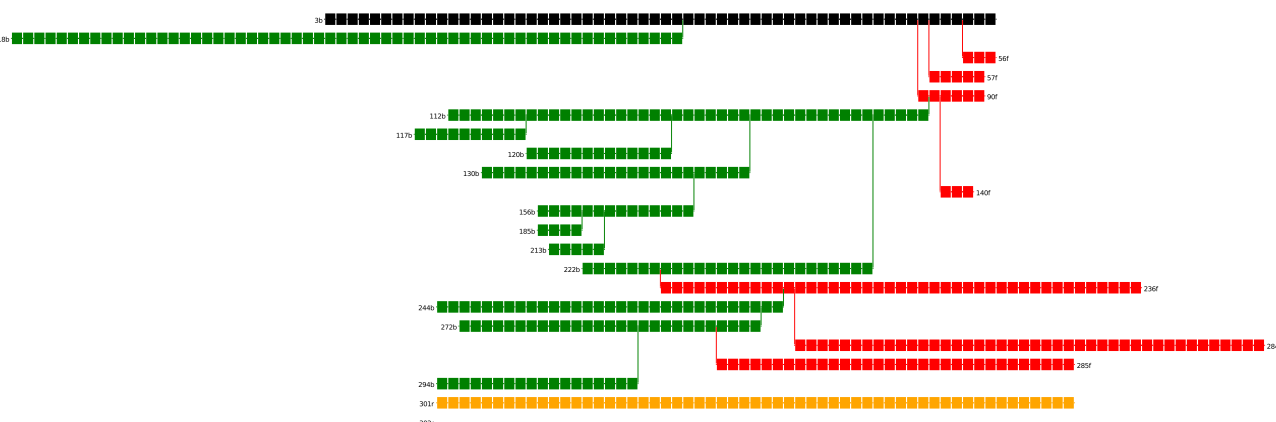

In [10]:
SVG(view.to_svg())

In [11]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 3 decorrelated trajectories.


In [12]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [13]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 20min, sys: 2min 12s, total: 22min 13s
Wall time: 22min 27s


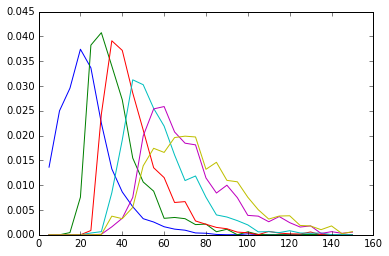

In [14]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

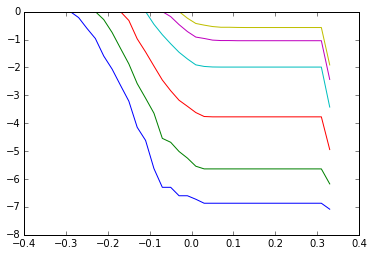

In [15]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

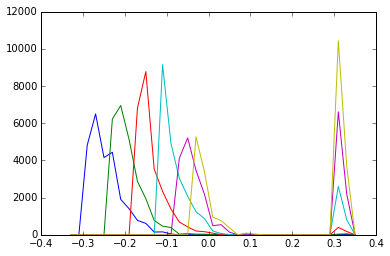

In [16]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

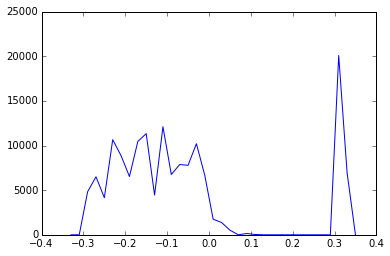

In [17]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.plot_bins(), total_sampling);

In [18]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

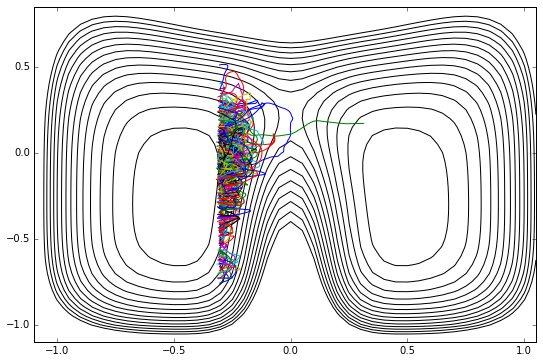

In [19]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [20]:
wham = retis.total_crossing_probability(method="wham")

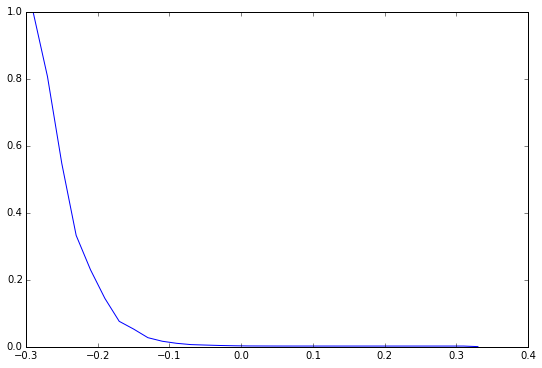

In [21]:
plt.plot(wham.keys(), wham.values());

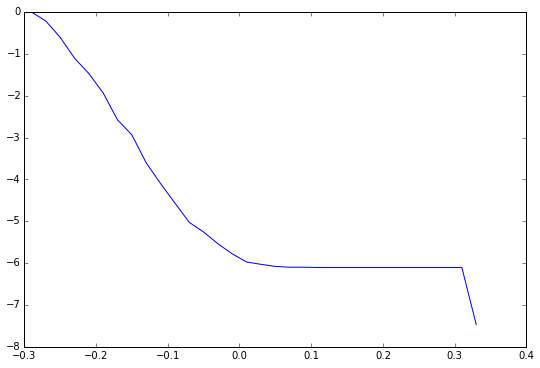

In [22]:
plt.plot(wham.keys(), np.log(wham.values()));

In [23]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 18.2 s, sys: 762 ms, total: 19 s
Wall time: 18.5 s


0.5650347972162227

In [24]:
retis.minus_move_flux(storage)

0.0024101109342927647

In [25]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

0.00241011093429 0.00521534157559 0.565034797216


In [26]:
outer_ens = retis.ensembles[-1]

outer_cross_prob = retis.histograms['max_lambda'][outer_ens]
lambda_bin = -1
while (outer_cross_prob.reverse_cumulative()[lambda_bin+1] == 1.0):
    lambda_bin += 1

outer_cross_lambda = outer_cross_prob.bins[lambda_bin]

In [27]:
retis.rate(storage)

IndexError: list index out of range

6.812935403999999e-06

6.8056179094211644e-06

In [28]:
0.00241011093429*0.00521534157559*0.565034797216

7.102234128331008e-06